In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

# Clustering with *Gaussian Mixture Models*

Clustering is one of the most popular applications of *unsupervised learning*. The goal of clustering algorithms is to group data into sets of observations with similar behavior. There are numerous real-world applications across various fields: for example, customer segmentation, where we group "similar" users; search engines, where we cluster similar results; and image compression, where pixels that correspond to the same objects are grouped together. A common trait among these applications is the absence of labeled data, unlike in supervised learning. If we already had labels indicating the group of each point, we wouldn’t need to perform any clustering algorithm, except when predicting labels for new data. In unsupervised learning, however, the primary challenge is discovering unknown patterns in the data.

The most well-known clustering technique is **K-Means**. In brief, it works by initially assigning points to K clusters based on randomly selected cluster centers, and then refining these clusters iteratively by recomputing the centers as the mean of the cluster points. However, this notebook will focus not on K-Means (you can refer to the `kmeans` notebook for that) but on another powerful approach: **Gaussian Mixture Models (GMMs).**

## Mixture of Gaussians: a theoretical introduction
One main drawback of K-Means is that it inherently groups points within hyperspheres, with the cluster radius defined by the furthest point from the cluster centroid. This approach is effective if the data exhibits spherical symmetry, but it may perform poorly otherwise. Another limitation is that K-Means is a **deterministic** algorithm that performs hard classification: each data point is assigned to exactly one cluster, without any probabilistic measure of that assignment.

Gaussian Mixture Models address both these limitations, although at the cost of a more complex algorithm. GMMs fall under the category of *density estimation* algorithms. The basic idea is to learn the probability density of data points and use that density for labeling unknown data. Since data can have complex structures, instead of learning a "simple" probability distribution like a single Gaussian or Beta distribution, GMMs use a probabilistic model where the underlying distribution is a linear combination of multiple basic distributions. This approach is effective for clustering because if our data is organized into $K$ clusters, we can model the overall distribution as a linear combination of $K$ basic distributions, which may not necessarily be spherical.

In general, Gaussian distributions are chosen as the building blocks because they work well in many applications. This approach addresses both drawbacks of K-Means clustering:
 - By combining (Gaussian) distributions with different means and variances, GMMs can model clusters with various shapes (elliptical in case of Gaussians), not limited to spherical symmetry;
- Learning a probability distribution allows for *soft* classification, where we know the probability that a point belongs to a given cluster.

Let now discuss how the model works. We consider a linear combinations of $K$ Gaussian densities of the form
$$
p(\boldsymbol{x}) = \sum_{k=1}^K \pi_k \mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$
which is called a *mixture of Gaussians*. Each Gaussian density is called a *component* of the mixture and it has its own mean $\boldsymbol{\mu}_k$ and covariance matrix $\boldsymbol{\Sigma}_k$. The parameters $\pi_k$ are called **mixing coefficients**. If we integrate both sides of the above equation:
$$
\int p(\boldsymbol{x}) d\boldsymbol{x} = 1 = \sum_{k=1}^K \pi_k \int \mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) d\boldsymbol{x}
$$
Since Gaussian distributions are normalized, we get
$$
\sum_{k=1}^K \pi_k = 1
$$
Also, given that $\mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \geq 0$, a sufficient condition for $p(\boldsymbol{x}) \geq 0$ is that the mixing coefficients be not vanishing for any $k$. Combining these finds, we get $$0 \leq \pi_k \leq 1$$ which means that $\pi_k$ can be theirselved considered as probabilities. From the sum and product rules of probabilities, we can then write the marginal density $p(\boldsymbol{x})$ as:
$$
p(\boldsymbol{x}) = \sum_{k=1}^K p(k) p(\boldsymbol{x} | k )
$$
In this context, we can view $\pi_k = p(k)$ as the **prior probability** of picking the $k$-th component of the Gaussian mixture and the Gaussian density $p(\boldsymbol{x} |k)$ as the probability of $\boldsymbol{x}$ conditioned on the $k$ component. If one is familiar with *Bayesian statistics*, he may be interested in the form of the so-called **posterior probability**, $p(k|\boldsymbol{x})$, which is basically the probability of $k$-th component *once* we have actually observed the data. According to the Bayes's theorem we can write:
$$
\begin{align}
\gamma_k(\boldsymbol{x}) \equiv p(k|\boldsymbol{x}) = \frac{p(k) p(\boldsymbol{x}| k)}{\sum_j p(j)p(\boldsymbol{x}|j)} = \frac{\pi_k \mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_j \pi_j \mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}
\end{align}
$$
The quantities $\gamma_k$ are known as **responsibilities**. They play a very important role in the theory of GMMs since they naturally emerge in the so-called maximum likelihood approach. Indeed, once we have defined the form of the mixture, we then need to learn the parameters governing the distribution. In this case, it means that we need to the set the values of $(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma})$. In the maximum-likelihood framework, this translates into maximizing the log of the likelihood function given by
$$
\ln p(\boldsymbol{X}, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum_{n=1}^N \ln \left(\sum_{k=1}^K \pi_k \mathcal{N} (\boldsymbol{x}|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)\right)
$$
where $\boldsymbol{X}$ is the set of data points $\{ \boldsymbol{x}_1, ..., \boldsymbol{x}_N\}$. The reader can easily prove that computing the derivative of the above function leads to an expression where responsibilities appear naturally.

The summation over $k$ inside the logarithm makes the optimization procedure far more complex than in K-means or in single density estimations. As a result, the maximum likelihood solution no longer has a closed-form analytical solution. Therefore, to maximize the likelihood function we need to use another approach. One strategy is to use iterative numerical optimization algorithms. However, in this notebook we will use another approach, the so-called **expectation-maximization** algorithm.

### Expectation-Maximization (EM)

In K-Means, the cost function being optimized is the sum of the squared distances between each data point and its assigned cluster center. In *naive* K-Means, this optimization happens in two stages: first, the cluster centers are fixed, and the cost function is optimized with respect to the cluster assignments, typically by assigning each data point to the nearest cluster center. In the second stage, the assignments are kept fixed, and the cost function is optimized with respect to the cluster centers by setting them to the mean of the data points belonging to each cluster, based on the results of the first step. These two stages are commonly known as the **Expectation (E)** and **Maximization (M)** steps of the **EM algorithm**. The EM algorithm can be applied in various contexts, including Gaussian Mixture Models (GMMs),
In particular, for GMMs, it works as follows:

1. We randomly initialize $\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}$ to some initial values;
2. <span style="color: blue">**Expectation**</span>: We evaluate the *responsibilities* using the current parameter values:

<div style="text-align: center; border: 2px solid blue; background-color: #E0F7FF; padding: 10px; display: inline-block;">
\[
\gamma_{nk} = \frac{\pi_k \mathcal{N} (\boldsymbol{x}_n|\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_j \pi_j \mathcal{N} (\boldsymbol{x}_n|\boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}
\]
</div>

3. <span style="color: blue">**Maximization**</span>: We re-estimate the parameters using the current responsibilities:

<div style="text-align: center; border: 2px solid blue; background-color: #E0F7FF; padding: 10px; display: inline-block;">
\[
\begin{gather} 
\boldsymbol{\mu}_k^{new} = \frac{1}{N_k} \sum_n^N \gamma_{nk}\boldsymbol{x}_n \\
\boldsymbol{\Sigma}_k^{new} = \frac{1}{N_k} \sum_n^N  \sum_n^N \gamma_{nk}(\boldsymbol{x}_n-\boldsymbol{\mu}_k^{new})(\boldsymbol{x}_n - \boldsymbol{\mu}_k^{new})^T \\
\pi_k^{new} = \frac{N_k}{N}
\end{gather}
\]
</div> $$N_k = \sum_n^N \gamma_{nk}$$

4. We evaluate the log likelihood and check for convergence.

Here, we won't delve into the theoretical justification of this procedure or the EM algorithm in general, as a thorough explanation would first require an understanding of the so-called *latent variables*. For those interested, references at the end of the notebook provide further reading on the topic.

Instead, we'll focus on how to use the native implementation of GMM in `scikit-learn` for clustering purposes, using a toy dataset as an example. In addition, we’ll also provide a simple implementation from scratch of the EM procedure. 

## GMMs with `sklearn`

To illustrate how to apply GMMs with scikit-learn, let consider a rather simple dataset, namely the famous *Old Faithful data set, which comprises 272 measurements of the eruption of the **Old Faithful geyser** at **Yellowstone National Park** in Wyoming, USA. 

![Old-Faithful](../images/old-faithful-geyser.jpg)

In [7]:
df = pd.read_csv("../datasets/old-faithful.csv", sep=",")

In [9]:
print(f"Number of measurements: {len(df)}")
print(f"Columns: {list(df.columns)}")

Number of measurements: 272
Columns: ['id', 'eruptions', 'waiting']


The dataset consists of 272 measurements of the duration of the eruption in minutes (`eruption`) and the time in minutes to the next eruption (`waiting`). By plotting the two features on a $xy$-plane, we see that:

Text(0.5, 1.0, 'Eruption duration and Waiting of the Old Faithful Geyser')

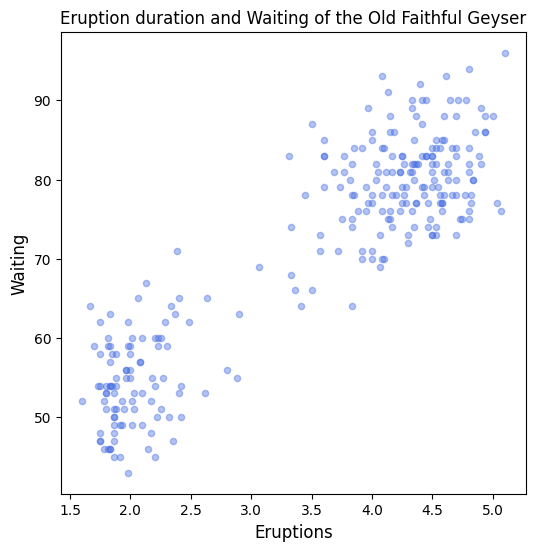

In [23]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(df["eruptions"], df["waiting"], c="royalblue", s=20, alpha=0.4)
ax.set_xlabel("Eruptions", fontsize=12)
ax.set_ylabel("Waiting", fontsize=12)
ax.set_title("Eruption duration and Waiting of the Old Faithful Geyser")

From the above plot, we see that eruptions exihibit a *bimodal* distribution in the two features, with two clusters clearly emerging. Such characteristic makes this geyser so popular, since its geothermal behavior is highly predictable. Let see what happens if we apply a standard K-Means to such dataset:

In [57]:
# subsetting features
X = df[["eruptions", "waiting"]].values

In [47]:
kmeans = KMeans(n_clusters = 2, random_state=42, max_iter=1000, tol=1e-5).fit(X)

In [58]:
# Extracting labels and cluster centers
kmeans_labels = kmeans.labels_
kmeans_centers = kmeans.cluster_centers_

In [59]:
kmeans_centers

array([[ 4.29793023, 80.28488372],
       [ 2.09433   , 54.75      ]])

In [49]:
color_dict = ["red" if x==1 else "blue" for x in kmeans_labels]

Text(0.5, 1.0, 'K-Means')

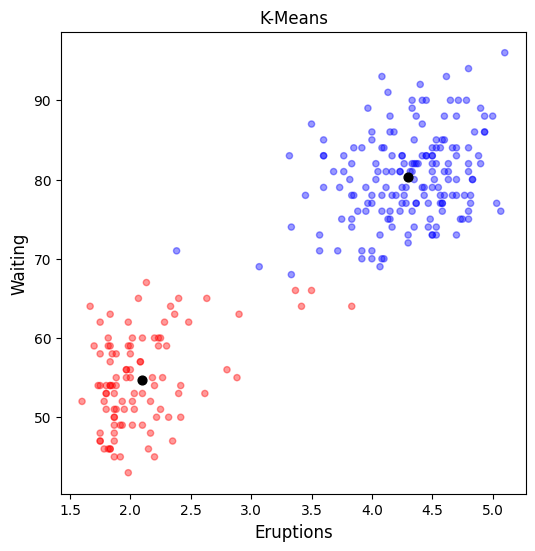

In [56]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(df["eruptions"], df["waiting"], c=color_dict, s=20, alpha=0.4)
ax.scatter(kmeans_centers[:,0], kmeans_centers[:,1], c="black", s=40)
ax.set_xlabel("Eruptions", fontsize=12)
ax.set_ylabel("Waiting", fontsize=12)
ax.set_title("K-Means")

We see that K-Means is working pretty well for points close enough to a cluster centroid but in the central, less dense, region the cluster assignment appears more arbitrary. Inspecting the graph, the blue point furthest to its cluster centroid, for instance, reasonably seems to be part of the red cluster rather than the blue one. However, as stated above, K-Means performes an hard assignment and therefore we do not have access to a probability estimate. 

Let's now see how we can improve clustering with GMMs. 

In [60]:
# create an instance of GaussianMixture 
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)

`covariance_type` is an important parameter of `GaussianMixture` in scikit-learn. According to the documentation ([GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)), it can takes the following arguments:

- `full`: each component has its own general covariance matrix;
- `tied`: all components share the same general covariance matrix;
- `diag`: each component has its own diagonal covariance matrix;
- `spherical`: each component has its own single variance.

The `full` case is the most general one, where each mixture component has its own covariance matrix; therefore, it is also the most expensive from a computational point of view. If you know well your dataset and you expect a less general situation where, for instance, all components do share the same covariances, then you can reduce the cost of the algorithm by selecting a less general argument such as `tied`. Above, we have set `full` since our dataset is rather small in size. 

In [61]:
# Let's fit the mixture model to the data
gmm.fit(X)

GaussianMixture(n_components=2, random_state=42)

In [62]:
# Predict the cluster for each data point
gmm_labels = gmm.predict(X)

Now we have cluster labels but the main advantage of GMMs is that they also provide us with a measure of probability for a point to belong to a given cluster. Let's get such probabilities and make a contour plot for a better visualization:

In [63]:
# Extracting x, y 
x = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
y = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)

In [83]:
# We repeat the x-coordinates and the y-coordinates respectively across rows and columns
Xx, Yy = np.meshgrid(x, y)

In [85]:
Xx.shape, Yy.shape

((100, 100), (100, 100))

In [86]:
# Now we flatten both 2D arrays Xx and Yy and stack them into an array. We can the transpose to get a (100x100, 2) dimensional array
XY = np.array([Xx.ravel(), Yy.ravel()]).T

In [87]:
XY.shape

(10000, 2)

In [88]:
# We get the log-likelihood of each sample
Z = -gmm.score_samples(XY)

In [89]:
Z.shape

(10000,)

In [93]:
# Notice that the shape of Z is 100x100. However, to make a contour plot we need to pass the coordinates of the values in Z, which in this case,
# are 100 values along x and along y, therefore we need to reshape Z to the same value of Xx or Yy
Z = Z.reshape(Xx.shape)

In [94]:
Z.shape

(100, 100)

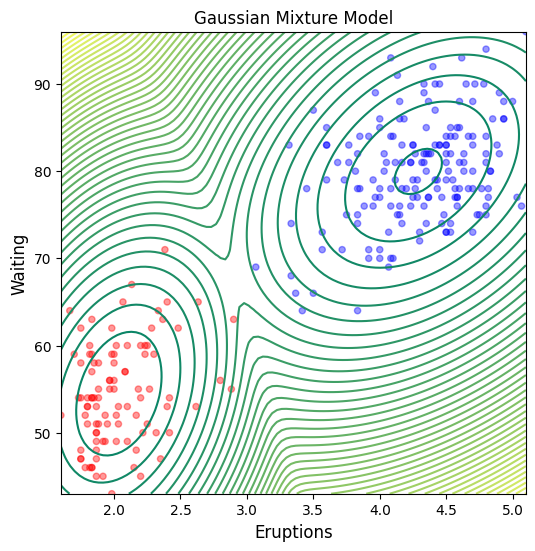

In [100]:
# Visualize clusters and contour
fig, ax = plt.subplots(figsize=(6,6))

gmm_colors = ["red" if x==1 else "blue" for x in gmm_labels]

ax.scatter(X[:, 0], X[:, 1], c=gmm_colors, s=20, alpha=0.4)

ax.set_xlabel("Eruptions", fontsize=12)
ax.set_ylabel("Waiting", fontsize=12)
ax.set_title("Gaussian Mixture Model")

# Plot the contour lines
plt.contour(Xx, Yy, Z, levels=50, cmap="summer", zorder=1)
plt.show()

The plot above clearly demonstrates the improvements of GMM over K-Means. Fitting a GMM to this dataset results in better clustering since the clusters are not constrained to be hyperspherical. This significantly impacts label assignment, particularly in regions with fewer data points. Additionally, visualizing the contour lines helps us better identify cluster domains.

In [101]:
weights, means, covariances = gmm.weights_, gmm.means_, gmm.covariances_

In [103]:
print(f"Weights: {weights}")
print(f"Means: {means}")
print(f"Covariances: {covariances}")

Weights: [0.64407255 0.35592745]
Means: [[ 4.28977944 79.96953298]
 [ 2.03652149 54.47986018]]
Covariances: [[[ 0.16982046  0.93871793]
  [ 0.93871793 36.02497019]]

 [[ 0.06927449  0.43627723]
  [ 0.43627723 33.70493352]]]


## Implementing GMMs and EM from scratch

Implementing machine learning algorithms from scratch is an excellent way to deepen your understanding of them. Below, we develop a Python class that fits a Gaussian mixture model to a given dataset using the EM framework. As mentioned in other notebooks of this project, the goal here is simply to make the discussion more complete by showing additional lines of code, not to provide a fast and optimized version of the algorithm, as these already exist and there's no need to reinvent the wheel.

In [155]:
class GMM:
    def __init__(self, n_components, n_iter=100, tol=1e-6):
        self.n_components = n_components
        self.n_iter = n_iter
        self.tol = tol
        self.log_likelihoods_ = []
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None

    def __initialize_parameters(self, X):
        
        n_samples, n_features = X.shape

        # Initialize means by taking randomly k points from the dataset
        means = X[np.random.choice(n_samples, self.n_components, False)]
        # Initialize covariances as identity matrices
        covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])
        # Initialize mixing coefficients (weights) 
        weights = np.ones(self.n_components)/self.n_components

        return means, covariances, weights


    def __E_step(self, X, means, covariances, weights):
        n_samples = X.shape[0]

        # Computing responsibilities
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            responsibilities[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])

        # We exploint the formula given in the introduction
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities /= responsibilities_sum
        
        return responsibilities


    def __M_step(self, X, responsibilities):
        n_samples, n_features = X.shape

        # Re-initializing means, covariances and weights
        means = np.zeros((self.n_components, n_features))
        covariances = np.zeros((self.n_components, n_features, n_features))
        weights = np.zeros(self.n_components)

        # Computing new means, covariances and weights using responsibilities
        for k in range(self.n_components):
            # taking the "k" element 
            resp_k = responsibilities[:, k]
            # Computing N_k
            total_resp_k = resp_k.sum()
            # Computing means, covariances and weghts
            means[k] = (X * resp_k[:, np.newaxis]).sum(axis=0) / total_resp_k
            X_centered = X - means[k]
            covariances[k] = np.dot(resp_k * X_centered.T, X_centered) / total_resp_k
            weights[k] = total_resp_k / n_samples
        
        return means, covariances, weights

    def fit(self, X):
        # Initiliaze at random
        means, covariances, weights = self.__initialize_parameters(X)
    
        for i in range(self.n_iter):
            responsibilities = self.__E_step(X, means, covariances, weights)
            means, covariances, weights = self.__M_step(X, responsibilities)
            
            # Compute log-likelihood
            log_likelihood = np.sum(np.log(np.dot(responsibilities, weights)))
            self.log_likelihoods_.append(log_likelihood)
            
            if i > 0 and np.abs(log_likelihood - self.log_likelihoods_[-2]) < self.tol:
                print(f"Convergence reached at iteration {i}")
                break
    
        self.means_ = means
        self.covariances_ = covariances 
        self.weights_ = weights 

    def predict(self, X):
        """Predict the cluster labels for each sample in X."""
        # Compute responsibilities
        responsibilities = self.__E_step(X, self.means_, self.covariances_, self.weights_)
        # Assign each sample to the cluster with the highest responsibility
        return np.argmax(responsibilities, axis=1)

    def score_samples(self, XY):
        """Compute the log-likelihood of each sample."""
        n_samples = X.shape[0]
        # Compute the probability density for each sample and component
        log_likelihood = np.zeros(n_samples)
        for k in range(self.n_components):
            log_likelihood += self.weights_[k] * multivariate_normal.pdf(X, mean=self.means_[k], cov=self.covariances_[k])
        # Return the log of the likelihood for each sample
        return np.log(log_likelihood)

In [148]:
myGMM = GMM(n_components=2, n_iter=500)

In [149]:
myGMM.fit(X)

Convergence reached at iteration 13


In [150]:
print(f"Weights: {myGMM.weights_}")
print(f"Means:  {myGMM.means_}")
print(f"Covariances: {myGMM.covariances_}")

Weights: [0.64412714 0.35587286]
Means:  [[ 4.28966197 79.96811519]
 [ 2.03638846 54.47851639]]
Covariances: [[[ 0.16996843  0.9406093 ]
  [ 0.9406093  36.04621111]]

 [[ 0.06916767  0.43516764]
  [ 0.43516764 33.69728215]]]


In [151]:
myGMM_labels = myGMM.predict(X)

In [156]:
myZ = myGMM.score_samples(XY)

In [158]:
myZ = myZ.reshape(Xx.shape)

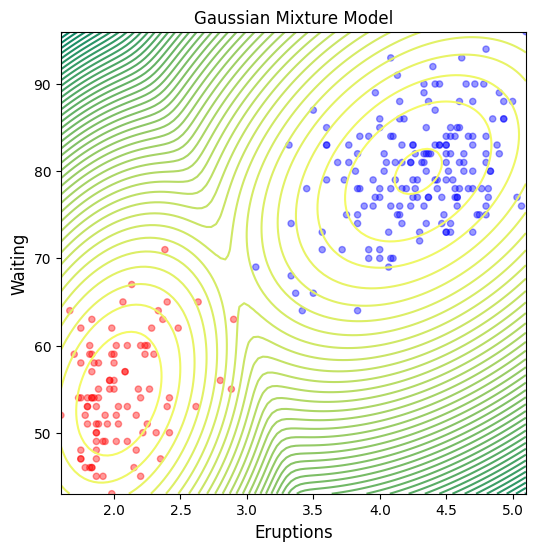

In [159]:
# Visualize clusters and contour
fig, ax = plt.subplots(figsize=(6,6))

mygmm_colors = ["red" if x==1 else "blue" for x in myGMM_labels]

ax.scatter(X[:, 0], X[:, 1], c=mygmm_colors, s=20, alpha=0.4)

ax.set_xlabel("Eruptions", fontsize=12)
ax.set_ylabel("Waiting", fontsize=12)
ax.set_title("Gaussian Mixture Model")

# Plot the contour lines
plt.contour(Xx, Yy, myZ, levels=50, cmap="summer", zorder=1)
plt.show()